In [64]:
import os
import sys
from glob import glob
import requests
import random
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from time import time

import torchvision
from albumentations import *

import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalcatface.xml')

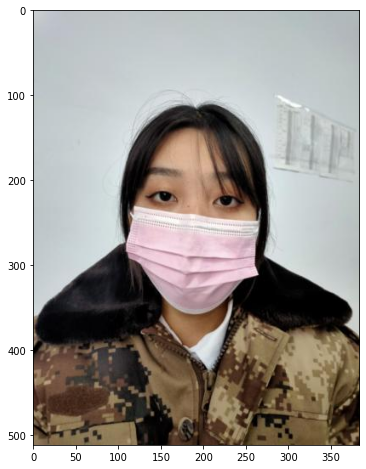

In [68]:
data_dir = '/opt/ml/input/data/train'

img_path = f'{data_dir}/images/003101_female_Asian_18/mask4.jpg'
img = cv2.imread(img_path)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16,8))
plt.imshow(img1)

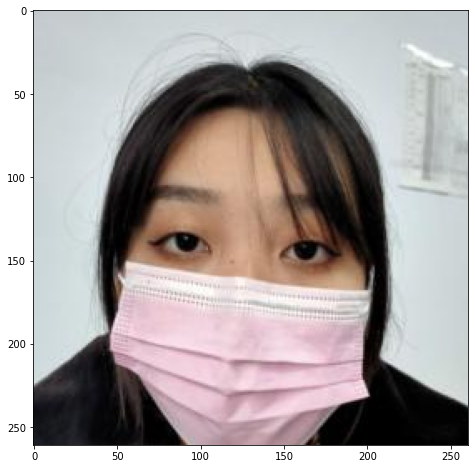

In [69]:
faces = face_cascade.detectMultiScale(img)
trfm = Compose([
            Resize(512,380),
        ], p=1.0)

x, y, w, h = faces[0]

cropped_img = img1[y - h // 4: y + h * 5// 4, x - w // 4: x + w * 5 // 4]
plt.figure(figsize=(16,8))
plt.imshow(cropped_img)

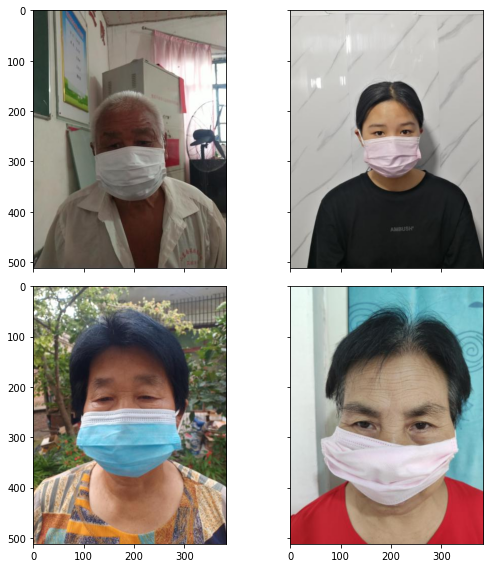

In [78]:
img_paths = glob(os.path.join(f'{data_dir}/images', '**/*'))
random.shuffle(img_paths)

n_rows, n_cols = 2, 2

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(8, 8))

trfm = torchvision.transforms.Compose([
            torchvision.transforms.Resize((512, 386))
        ])

for i in range(n_rows*n_cols):
    _img = cv2.imread(img_paths[i])
    _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
    faces = face_cascade.detectMultiScale(_img)
#     뭔가 인식이 안되면 값을 안뱉음 ...
    if len(faces) != 1:
        axes[i%n_rows][i//n_cols].imshow(_img)
        continue
    x, y, w, h = faces[0]
    cropped_img = _img[y: y + h, x: x + w]
    axes[i%n_rows][i//n_cols].imshow(Image.fromarray(trfm(cropped_img)))
    
plt.tight_layout()

Cutout

In [96]:
def cutout(mask_size, p, cutout_inside, mask_color=(0, 0, 0)):
    mask_size_half = mask_size // 2
    offset = 1 if mask_size % 2 == 0 else 0

    def _cutout(image):
        image = np.asarray(image).copy()

        if np.random.random() > p:
            return image

        h, w = image.shape[:2]

        if cutout_inside:
            cxmin, cxmax = mask_size_half, w + offset - mask_size_half
            cymin, cymax = mask_size_half, h + offset - mask_size_half
        else:
            cxmin, cxmax = 0, w + offset
            cymin, cymax = 0, h + offset

        cx = np.random.randint(cxmin, cxmax)
        cy = np.random.randint(cymin, cymax)
        xmin = cx - mask_size_half
        ymin = cy - mask_size_half
        xmax = xmin + mask_size
        ymax = ymin + mask_size
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(w, xmax)
        ymax = min(h, ymax)
        image[ymin:ymax, xmin:xmax] = mask_color
        return Image.fromarray(image)

    return _cutout

In [97]:
h = 195

trfm0 = torchvision.transforms.Compose([
            cutout(mask_size= h // 2, p=1 ,cutout_inside=False),
            torchvision.transforms.Resize(240)
        ])


trfm1 = torchvision.transforms.Compose([
            cutout(mask_size= h // 3, p=1, cutout_inside=False),
            torchvision.transforms.Resize(240)
        ])

trfm2 = torchvision.transforms.Compose([
            cutout(mask_size= h // 4, p=1, cutout_inside =False),
            torchvision.transforms.Resize(240)
        ])


cutoff 크기를 어느정도 해야될까?

x = 102, y = 193, h = 195, w = 176

얼굴크기가 176 * 195 정도 되는데 마스크 크기를 w * h // 2 정도라고 가정


cutoff 크기를 h // 4, h // 2 로 해봤을 때 차이 보자

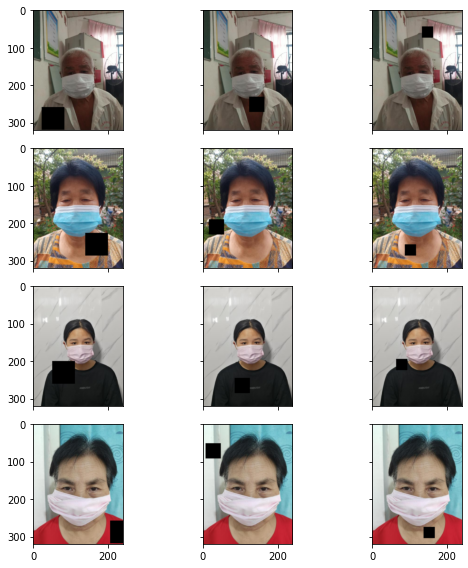

In [98]:
n_rows, n_cols = 4, 3

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(8, 8))

for i in range(0, n_rows):
    _img = cv2.imread(img_paths[i])
    _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
    axes[i%n_rows][0].imshow(trfm0(_img))
    axes[i%n_rows][1].imshow(trfm1(_img))
    axes[i%n_rows][2].imshow(trfm2(_img))
plt.tight_layout()

centercrop 이후 중앙에서 cutout

In [105]:
def cutout(mask_size, p, mask_color=(0, 0, 0)):
    mask_size_half = mask_size // 2
    offset = 1 if mask_size % 2 == 0 else 0

    def _cutout(image):
        image = np.asarray(image).copy()

        if np.random.random() > p:
            return image

        h, w = image.shape[:2]

        cx, cy = w // 2, h // 2
        xmin = cx - mask_size_half
        ymin = cy - mask_size_half
        xmax = xmin + mask_size
        ymax = ymin + mask_size
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(w, xmax)
        ymax = min(h, ymax)
        image[ymin:ymax, xmin:xmax] = mask_color
        return Image.fromarray(image)

    return _cutout

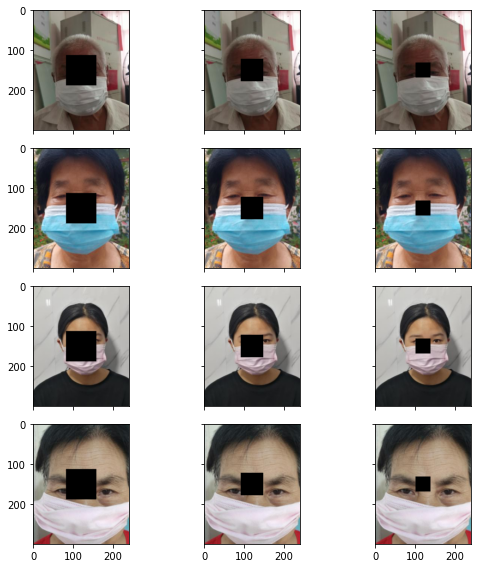

In [111]:
trfm0 = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.CenterCrop((320, 256)),
            cutout(mask_size= h * 2* 320 // 512 // 3, p=1),
            torchvision.transforms.Resize(240)
        ])

trfm1 = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.CenterCrop((320, 256)),
            cutout(mask_size= h * 320 // 512 // 2, p=1),
            torchvision.transforms.Resize(240)
        ])

trfm2 = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.CenterCrop((320, 256)),
            cutout(mask_size= h * 320 // 512 // 3, p=1),
            torchvision.transforms.Resize(240)
        ])

n_rows, n_cols = 4, 3

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(8, 8))

for i in range(0, n_rows):
    _img = cv2.imread(img_paths[i])
    _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
    axes[i%n_rows][0].imshow(trfm0(_img))
    axes[i%n_rows][1].imshow(trfm1(_img))
    axes[i%n_rows][2].imshow(trfm2(_img))

plt.tight_layout()

모델 불러오기

In [ ]:
import torchvision.models as models
class EfficientNet_B1(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        """
        1. 위와 같이 생성자의 parameter 에 num_claases 를 포함해주세요.
        2. 나만의 모델 아키텍쳐를 디자인 해봅니다.
        3. 모델의 output_dimension 은 num_classes 로 설정해주세요.
        """
        self.backbone = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
        self.classifier = nn.Linear(1000, num_classes)

        self.name = "EfficientNet_b1"

        self.init_params()
    def forward(self, x):
        """
        1. 위에서 정의한 모델 아키텍쳐를 forward propagation 을 진행해주세요
        2. 결과로 나온 output 을 return 해주세요
        """
        x = self.backbone(x)
        x = self.classifier(x)
        return x

    def init_params(self):
        nn.init.kaiming_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)

def load_model(saved_model, num_classes, device):
    model_path = os.path.join(saved_model, 'best.pth')
    model.load_state_dict(torch.load(model_path, map_location=device))

model_dir = 'opt/ml/v2/model/exp2'
num_classes = 18
device = torch.device("cuda" if use_cuda else "cpu")
model = load_model(model_dir, num_classes, device).to(device)
model.eval()

trmf = torchvision.transforms.Compose([
            torchvision.transforms.CenterCrop((320, 256)),
            torchvision.transforms.Resize(240),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=mean, std=std),
        ])